# SuperPoint

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import random


## prepare dataset
为每个数据集生成.csv文件，方便目录的管理

In [2]:
dataset_root = '/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/dataset/data'

first_dir_names = ['draw_checkerboard',
             'draw_cube',
             'draw_ellipses',
             'draw_lines',
             'draw_multiple_polygons',
             'draw_polygon',
             'draw_star',
             'draw_stripes',
             'gaussian_noise']

second_images_dir_name = 'images'
second_pts_dir_name = 'points'

dataset_dir_name = {'train':'training','test':'test','val':'validation'}



In [3]:
def gen_csv():
    for value in dataset_dir_name.values():
        print(f'生成{value}.csv')
        df = pd.DataFrame(columns=['imgs_path','pts_path'])
        for first_dir_name in first_dir_names:
            imgs_prefix = os.path.join(first_dir_name,
                                            second_images_dir_name,
                                            value)
            for _,_,imgs in os.walk(os.path.join(dataset_root,
                                            first_dir_name,
                                            second_images_dir_name,
                                            value)):
                imgs_ret = sorted(imgs)
                imgs_ret = [os.path.join(imgs_prefix,img) for img in imgs_ret]
                imgs_ret = pd.Series(imgs_ret)

            pts_prefix = os.path.join(first_dir_name,
                                            second_pts_dir_name,
                                            value)
            for _,_,pts in os.walk(os.path.join(dataset_root,
                                            first_dir_name,
                                            second_pts_dir_name,
                                            value)):
                pts_ret = sorted(pts)
                pts_ret = [os.path.join(pts_prefix,pt) for pt in pts_ret]
                pts_ret = pd.Series(pts_ret)

            ret = pd.DataFrame({'imgs_path':imgs_ret,'pts_path':pts_ret})
            df = df.append(ret)
        print('检查路径对齐是否正确...') 
        
        
        for i in tqdm(range(len(df))):
            img_path = df.iloc[i,:]['imgs_path']
            pt_path = df.iloc[i,:]['pts_path']
            if img_path.split('/')[-1].split('.')[0] != pt_path.split('/')[-1].split('.')[0]:
                print('error,i=',i)
                break
        else:
            print('OK')
            df.to_csv(f'{value}.csv')

In [4]:
# gen_csv()

In [5]:
H,W = 120,160
Hc,Wc = int(H/8),int(W/8)

## Dataset类，标签转化是重点

In [6]:
class SyntheticData(Dataset):
    def __init__(self,csv_file,dataset_root,save_point=False):
        self.csv = pd.read_csv(csv_file)
        self.dataset_root = dataset_root
        self.save_point = save_point
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, idx):
        item = self.csv.iloc[idx]
        img_path = os.path.join(self.dataset_root,item['imgs_path'])
        pt_path = os.path.join(self.dataset_root,item['pts_path'])
        img = plt.imread(img_path)
        pt = np.load(pt_path)
        if self.save_point:            
            sample = {'img':img,'label':point2label(pt),'pt':pt}
        else:
            sample = {'img':img,'label':point2label(pt)}
        return sample
    
def point2label(pts):
    label = 64 * np.ones((Hc,Wc),dtype=int)
    for pt in pts:
        i = int(pt[0]) // 8
        j = int(pt[1]) // 8
        k = int(pt[0]) % 8
        l = int(pt[1]) % 8
        if label[i,j] == 64:
            label[i,j] = int(k*8+l)
            #print(pt,'->',f'label[{i},{j}]={label[i,j]}')
        else:
            if random.randint(1,2) == 1:
                label[i,j] = k*8+l
                #print(pt,'->',f'label[{i},{j}]={label[i,j]}','recover')
    return label

def label2point(label):
    ret = []
    for i in range(Hc):
        for j in range(Wc):
            if label[i,j]!=64:
                x = label[i,j] // 8 + i*8
                y = label[i,j] % 8 + j*8
                ret.append([x,y])
    return np.array(ret)

def visulize(img,label=None,pt=None):
    img = img.squeeze()
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    if label is not None:
        for i in range(Hc):
            for j in range(Wc):
                x,y = i*8,j*8
                if label[i,j] == 64:
                    continue
                k,l = label[i,j] // 8,int(label[i,j])%8
                plt.gca().add_patch(plt.Rectangle((y,x),8,8,color='r',fill=False,linewidth=2))
    if pt is not None and len(pt) != 0:
        plt.scatter(pt[:,1],pt[:,0])
    plt.show()

In [7]:
train_csv = '/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/model/training.csv'
test_csv = '/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/model/test.csv'
val_csv = '/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/model/validation.csv'

train_data = SyntheticData(train_csv,dataset_root)
batch_size = 16
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

### 对比
point转化为label之后，会有精度的损失，因为point本身是float的，而label只能覆盖到每一个整点位置，在这里对比以下转化前后点的位置变化

转化前


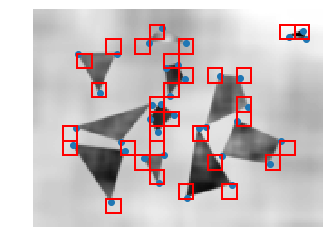

转化后


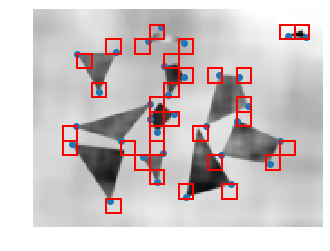

In [10]:
# train_data_with_point = SyntheticData(train_csv,dataset_root,True)
# sample =train_data_with_point[40800]
# # print(sample['pt'])
# img,label,points = sample['img'],sample['label'],sample['pt']
# # print(label)
# pt = label2point(label)
# print("转化前")
# visulize(img,label,points)
# print("转化后")
# visulize(img,label,pt)

转化后，每个框中只有一个关键点，且点的位置均向左上角有微小偏移，这是因为向下取整的缘故

## 查看数据集

In [8]:
def input_sample():
    for i,sample in enumerate(train_loader):
        imgs = sample['img']
        labels = sample['label']
        for j in range(batch_size):
            img = imgs[j]
            label = labels[j]
            points = label2point(label)
            visulize(img,label,points)
        if i == 0:
            break

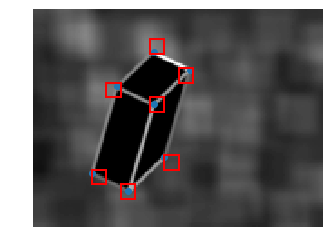

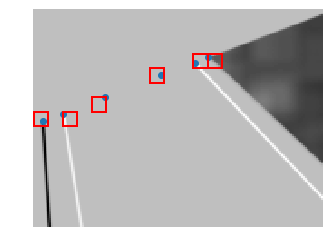

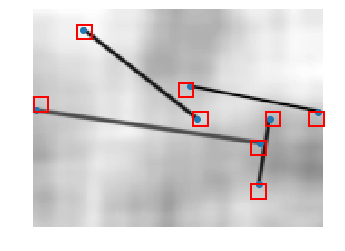

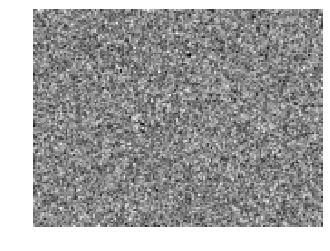

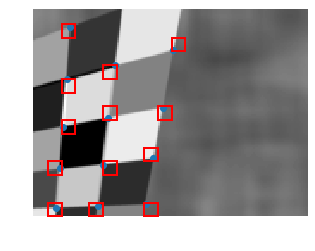

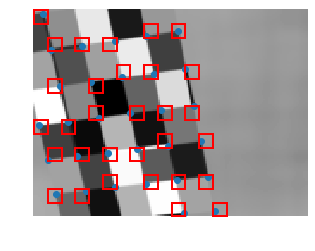

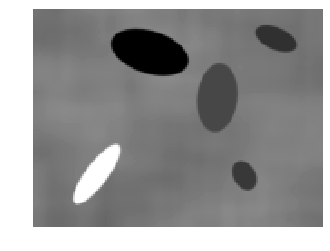

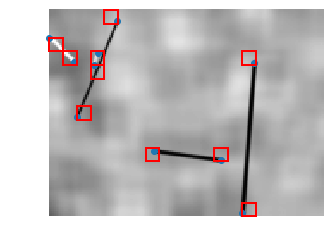

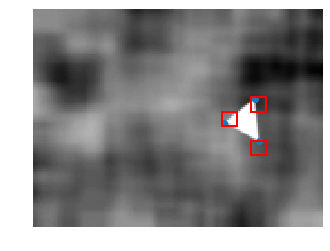

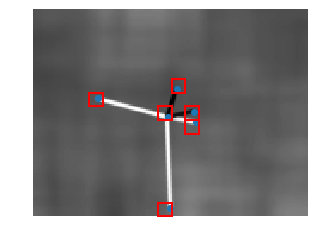

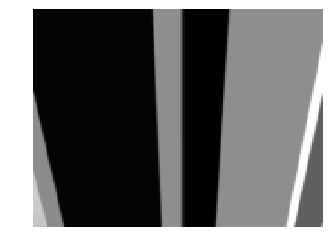

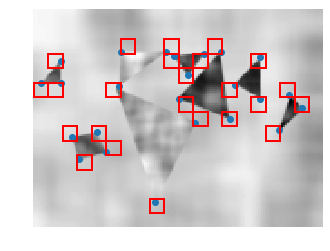

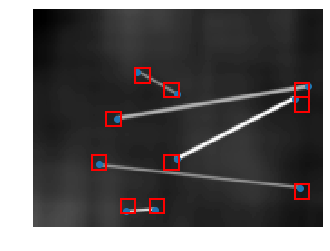

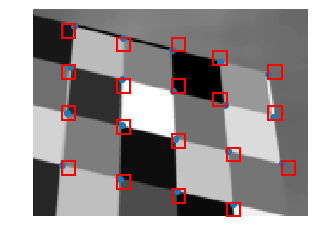

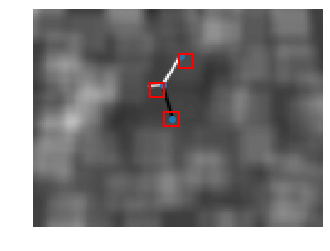

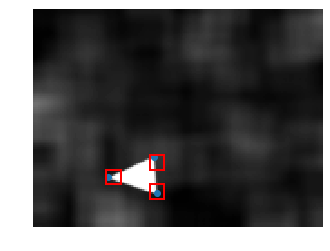

In [9]:
input_sample()

## 定义网络

In [10]:
class SuperPointNet(torch.nn.Module):
    """ Pytorch definition of SuperPoint Network. """

    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = torch.nn.ReLU(inplace=True)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """ Forward pass that jointly computes unprocessed point and descriptor
        tensors.
        Input
          x: Image pytorch tensor shaped N x 1 x H x W.
        Output
          semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
          desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
        """
        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))

        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
#         cDa = self.relu(self.convDa(x))
#         desc = self.convDb(cDa)
#         dn = torch.norm(desc, p=2, dim=1)  # Compute the norm.
#         desc = desc.div(torch.unsqueeze(dn, 1))  # Divide by norm to normalize.
        return semi #, desc

net = SuperPointNet()

## 采样显示输出

In [11]:
def sample_output():
    for i,sample in enumerate(train_loader):
        imgs = sample['img'].view((-1,1,H,W))
        labels = sample['label']
        print(imgs.shape)
        outputs = net(imgs)
        
        if i == 0:
            return imgs,labels,outputs
        
        
def output2points(output,alpha=0.5):
    output = np.exp(output.detach().numpy()) # Softmax.
    output = output / (np.sum(output, axis=0) + .00001)  # Should sum to 1.
    output = output[:-1,:,:]
    output = output.transpose(1,2,0)
    output = output.reshape((Hc,Wc,8,8))
    output = output.transpose(0,2,1,3)
    output = output.reshape(H,W)
    # print(output.shape)
    # print(output[output > alpha])
    xs,ys = np.where(output > alpha)
    points = np.vstack((xs,ys)).T
    print(f'there are {len(points)} points')
    return points

torch.Size([16, 1, 120, 160])
torch.Size([1, 120, 160])
there are 918 points


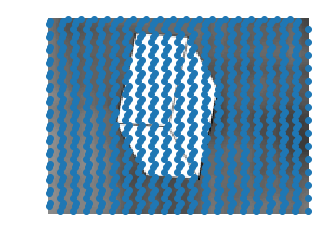

In [12]:
imgs,labels,outputs = sample_output()
img = imgs[0]
print(img.shape)
label = labels[0]
output = outputs[0]

points = output2points(output,alpha=0.0163)
visulize(img,pt=points)

## 开始训练

In [24]:
net = SuperPointNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=net.parameters(),lr=0.0001)

In [25]:
n_epoch = 10
running_loss = 0
for epoch in range(n_epoch):
    for i,sample in enumerate(train_loader):
        imgs = sample['img'].view((-1,1,H,W))
        labels = sample['label']
        
        outputs = net(imgs)
        loss = criterion(outputs,labels)
#         for i in range(Hc):
#             for j in range(Wc):
#                 # print(outputs[:,:,i,j].shape,labels[:,i,j].shape)
#                 loss += criterion(outputs[:,:,i,j],labels[:,i,j])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        
        if i%10 == 9:
            print(f"epoch:{epoch+1},batch:{i+1},AVG.loss:{running_loss/batch_size/10}")
            running_loss = 0.0

epoch:1,batch:10,AVG.loss:0.34055498242378235
epoch:1,batch:20,AVG.loss:0.26322048902511597
epoch:1,batch:30,AVG.loss:0.26314666867256165
epoch:1,batch:40,AVG.loss:0.26307958364486694
epoch:1,batch:50,AVG.loss:0.2630019187927246
epoch:1,batch:60,AVG.loss:0.26292601227760315
epoch:1,batch:70,AVG.loss:0.2628517150878906
epoch:1,batch:80,AVG.loss:0.26277869939804077
epoch:1,batch:90,AVG.loss:0.2627224028110504
epoch:1,batch:100,AVG.loss:0.26262953877449036
epoch:1,batch:110,AVG.loss:0.2625649869441986
epoch:1,batch:120,AVG.loss:0.26249510049819946
epoch:1,batch:130,AVG.loss:0.2624169588088989


Traceback (most recent call last):
  File "/usr/lib64/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib64/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib64/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib64/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib64/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib64/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib64/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib64/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write

KeyboardInterrupt: 

In [184]:
labels.shape

torch.Size([16, 15, 20])

In [186]:
labels[:,1,1].shape

torch.Size([16])

In [187]:
outputs[:,:,1,1].shape

torch.Size([16, 65])

## 检查网络可能存在的问题

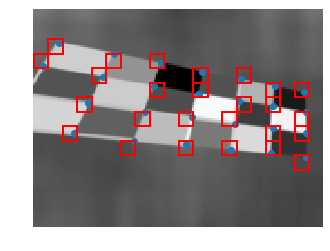

In [14]:
sample = train_data[0]
visulize(sample['img'],sample['label'],label2point(sample['label']))

In [203]:
net = SuperPointNet()
optimizer = optim.SGD(net.parameters(),lr=0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [205]:
from time import sleep
train_time = 1000000
running_loss = 0.0
for i in range(train_time):
    img = torch.from_numpy(sample['img']).view(1,1,120,160)
    label = torch.from_numpy(sample['label']).view(1,15,20)
    
    
    outputs = net(img)
    
    loss = criterion(outputs,label)
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    running_loss += loss.data
    
    if loss.data < 0.1:
        print("less than 0.1",loss.data)
        break
    
    if i%100==99:
        sleep(2)
        print("AVG loss:",running_loss/100)
        running_loss = 0

AVG loss: tensor(0.5593)
AVG loss: tensor(0.5500)
AVG loss: tensor(0.5434)


KeyboardInterrupt: 

In [127]:
def visualize_heatmap(img,outputs,alpha=0.0000050):
    plt.figure()
    plt.subplot(121)
    
    img = np.squeeze(img)
    
    plt.imshow(img,cmap='gray')
    
    outputs = np.squeeze(outputs.detach().numpy())
    outputs = np.exp(outputs)
    
    outputs = outputs/np.sum(outputs)
    
    outputs = outputs[:-1,:,:]
    outputs = outputs.reshape(8,8,15,20)
    outputs = outputs.transpose([2,0,3,1])
    outputs = outputs.reshape(120,160)
    
    x,y=np.where(outputs>=alpha)
    print('max point:',x,y)
    plt.scatter(y,x)
    
    plt.subplot(122)
    plt.imshow(outputs)
    print(outputs)
    print(f"max :{np.max(outputs):.7f}")
    print(f"min :{np.min(outputs):.7f}")
    print("dim :",outputs.shape)
    print("sum :",np.sum(outputs))
    print("dim1 sum:",np.sum(outputs,axis=0))
    
def output2heatmap(outputs):
    outputs = np.squeeze(outputs.detach().numpy())
    outputs = np.exp(outputs)
    
    outputs = outputs/(np.sum(outputs)+0.00001)
    
    outputs = outputs[:-1,:,:]
    outputs = outputs.reshape(8,8,15,20)
    outputs = outputs.transpose([2,0,3,1])
    outputs = outputs.reshape(120,160)
    return outputs

[[5.1180235e-05 4.8114482e-05 5.0005237e-05 ... 5.0410104e-05
  4.8610662e-05 5.2983731e-05]
 [4.8360453e-05 5.2135911e-05 5.3314132e-05 ... 4.9316728e-05
  5.1088300e-05 4.9412207e-05]
 [5.2875737e-05 5.1353589e-05 5.0318547e-05 ... 5.1165269e-05
  4.8635728e-05 5.4409822e-05]
 ...
 [5.4327444e-05 5.0226769e-05 5.3048068e-05 ... 5.2439587e-05
  4.8910642e-05 4.9408369e-05]
 [5.0343224e-05 4.9933871e-05 4.9062492e-05 ... 5.2412721e-05
  5.4557608e-05 4.8640584e-05]
 [4.8633046e-05 4.8413673e-05 5.3084012e-05 ... 5.1325169e-05
  4.9602142e-05 5.4237495e-05]]
max :0.0001
min :0.0000
dim : (120, 160)
sum : 0.9834813


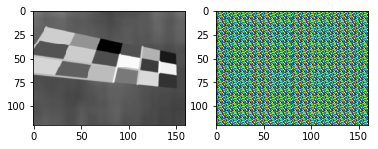

In [43]:
visualize_heatmap(img,outputs)

[[5.1006307e-05 4.8016784e-05 4.9862349e-05 ... 5.0378585e-05
  4.8487454e-05 5.2846306e-05]
 [4.8283226e-05 5.2016072e-05 5.3156313e-05 ... 4.9289560e-05
  5.1125913e-05 4.9069353e-05]
 [5.2756783e-05 5.1269370e-05 5.0476276e-05 ... 5.0951476e-05
  4.8648897e-05 5.4375821e-05]
 ...
 [5.4141652e-05 5.0215793e-05 5.2859981e-05 ... 5.2041720e-05
  4.8796934e-05 4.9048325e-05]
 [5.0172348e-05 4.9697854e-05 4.8879072e-05 ... 5.2446245e-05
  5.4262873e-05 4.8488866e-05]
 [4.8614627e-05 4.8210182e-05 5.2638719e-05 ... 5.1025396e-05
  4.9368376e-05 5.4042124e-05]]
max :0.0001
min :0.0000
dim : (120, 160)
sum : 0.9800916


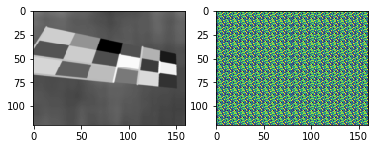

In [47]:
visualize_heatmap(img,outputs)

[[2.2518714e-06 2.2221386e-06 2.0174725e-06 ... 2.2946647e-06
  2.1831058e-06 2.7572930e-06]
 [2.1791054e-06 2.3109524e-06 2.3738639e-06 ... 2.4065705e-06
  2.5444717e-06 2.1693124e-06]
 [2.7158649e-06 2.4194035e-06 2.5563454e-06 ... 2.2901716e-06
  2.0894140e-06 2.6027406e-06]
 ...
 [2.5677177e-06 2.3780499e-06 2.3681630e-06 ... 1.8133844e-06
  2.1727003e-06 1.9961808e-06]
 [2.3531970e-06 2.1966027e-06 2.2836732e-06 ... 2.6977343e-06
  2.4059166e-06 2.1049775e-06]
 [2.1793549e-06 2.0863749e-06 2.0666766e-06 ... 2.2243844e-06
  2.1375904e-06 2.4720059e-06]]
max :0.0000
min :0.0000
dim : (120, 160)
sum : 0.042542994
dim1 sum: [0.00028076 0.00027048 0.00026432 0.00027397 0.00028066 0.0002727
 0.00026411 0.00027809 0.00027337 0.00026765 0.00025478 0.00026716
 0.00027519 0.00026684 0.0002542  0.000274   0.00027133 0.00026696
 0.00025256 0.00026544 0.00027375 0.00026566 0.00025174 0.00027274
 0.00027103 0.00026693 0.00025221 0.00026521 0.00027354 0.00026547
 0.00025141 0.00027256 0.00027102

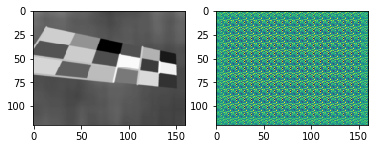

In [57]:
visualize_heatmap(img,outputs)

[[3.9854540e-06 3.9024144e-06 3.5712492e-06 ... 4.2012730e-06
  4.0038985e-06 4.9920395e-06]
 [3.8432381e-06 4.0759742e-06 4.1818362e-06 ... 4.2246420e-06
  4.6107243e-06 3.8324229e-06]
 [4.7070771e-06 4.4452349e-06 4.6781702e-06 ... 4.3879631e-06
  3.8558051e-06 4.5570514e-06]
 ...
 [4.4857202e-06 4.1781577e-06 4.1573835e-06 ... 3.5294283e-06
  4.1779140e-06 3.5367200e-06]
 [4.1116959e-06 3.8758344e-06 4.1728840e-06 ... 4.6789178e-06
  4.2024867e-06 3.7257132e-06]
 [3.8421481e-06 3.6912543e-06 3.6786844e-06 ... 4.0260629e-06
  3.7683062e-06 4.5384218e-06]]
max :0.0000056
min :0.0000026
dim : (120, 160)
sum : 0.07661844
dim1 sum: [0.00049013 0.0004784  0.0004718  0.0004877  0.00050431 0.00049578
 0.0004911  0.00049797 0.00047473 0.00047134 0.00045571 0.00047595
 0.00049652 0.00048682 0.00048274 0.00049305 0.00047131 0.00047018
 0.00045244 0.00047341 0.00049487 0.00048492 0.00048139 0.00049163
 0.00047094 0.00047011 0.00045208 0.00047319 0.00049472 0.00048474
 0.00048129 0.00049152 0.00

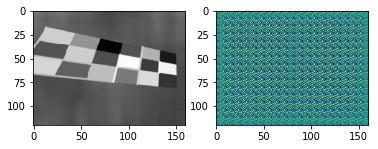

In [61]:
visualize_heatmap(img,outputs)

max point: [  8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16
  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24
  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32
  40  40  40  40  40  40  40  40  40  40  40  40  40  40  40  40  40  40
  48  48  48  48  48  48  48  48  48  48  48  48  48  48  48  48  48  48
  56  56  56  56  56  56  56  56  56  56  56  56  56  56  56  56  56  56
  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64
  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88
  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96  96
 104 104 104 104 104 104 104 104 104 104 104 104 104 104 104 104 104 104] [ 15  23  31  39  47  55  63  71  79  8

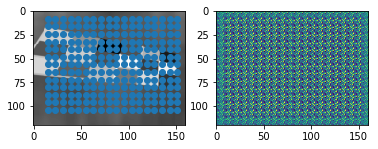

In [84]:
visualize_heatmap(img,outputs,0.00000577)

In [86]:
heatmap = output2heatmap(outputs)

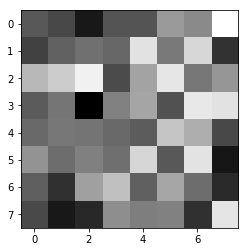

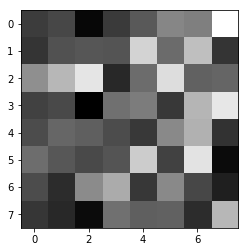

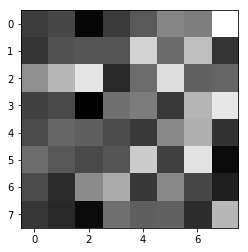

[[0.6559287  0.6381422  0.5833142  0.6515266  0.6509964  0.73174536
  0.71274877 0.8476585 ]
 [0.6299787  0.66725713 0.6833993  0.6728437  0.8144367  0.69395167
  0.8009785  0.6122591 ]
 [0.7663862  0.7884159  0.8315805  0.64154243 0.74312246 0.8184191
  0.69201034 0.72667974]
 [0.6594163  0.6893127  0.5549041  0.7034419  0.74391836 0.6484544
  0.82089865 0.8139459 ]
 [0.6760604  0.6920424  0.68849826 0.6753958  0.660452   0.7807102
  0.75482553 0.63795227]
 [0.72372276 0.6804156  0.7018367  0.681928   0.8005152  0.6557702
  0.81563896 0.58104634]
 [0.6641087  0.6116043  0.73833156 0.77462226 0.66523135 0.7448097
  0.6799156  0.6029831 ]
 [0.63867223 0.5827652  0.6011262  0.7174896  0.69987017 0.7030945
  0.6102636  0.8170806 ]]


In [92]:
plt.imshow(heatmap[:8,:8],cmap='gray')
plt.show()
plt.imshow(heatmap[5*8:6*8,7*8:8*8],cmap='gray')
plt.show()
plt.imshow(heatmap[3*8:4*8,12*8:13*8],cmap='gray')
plt.show()
print(heatmap[:8,:8]/np.max(heatmap))

max point: [ 13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  21
  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  29  29
  29  29  29  29  29  29  29  29  29  29  29  29  29  29  29  37  37  37
  37  37  37  37  37  37  37  37  37  37  37  37  37  37  45  45  45  45
  45  45  45  45  45  45  45  45  45  45  45  45  45  53  53  53  53  53
  53  53  53  53  53  53  53  53  53  53  53  53  61  61  61  61  61  61
  61  61  61  61  61  61  61  61  61  61  61  69  69  69  69  69  69  69
  69  69  69  69  69  69  69  69  69  69  77  77  77  77  77  77  77  77
  77  77  77  77  77  77  77  77  77  85  85  85  85  85  85  85  85  85
  85  85  85  85  85  85  85  85  93  93  93  93  93  93  93  93  93  93
  93  93  93  93  93  93  93 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109] [ 14  22  30  38  46  54  62  70  78  86  94 102 110 118 126 134 142  14
  22  30  38  

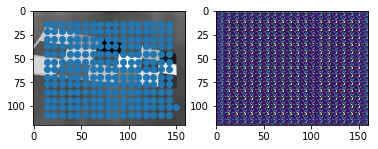

In [97]:
# 1000+
visualize_heatmap(img,outputs,0.000013)

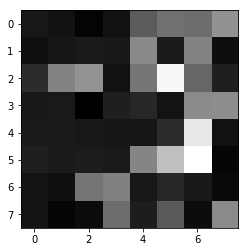

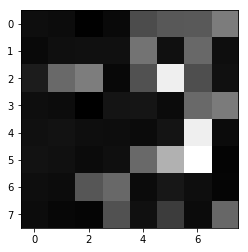

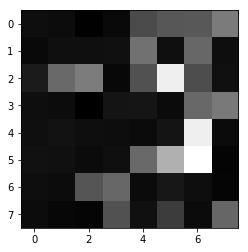

[[0.229955   0.21863227 0.19777896 0.2189559  0.33850142 0.37507796
  0.36889532 0.4292085 ]
 [0.21671298 0.22730115 0.2336367  0.22989433 0.4131255  0.23503649
  0.40414596 0.2145596 ]
 [0.26499015 0.40420932 0.43208638 0.21976212 0.38237032 0.59413594
  0.35791996 0.24262393]
 [0.23019159 0.23251802 0.19088814 0.24184418 0.2544502  0.22172943
  0.41677994 0.4210766 ]
 [0.23438674 0.23378529 0.2306075  0.22808772 0.22641064 0.26226136
  0.56825256 0.21981609]
 [0.24210662 0.23457664 0.23704493 0.2329602  0.40717065 0.5011471
  0.60611933 0.19987243]
 [0.22448918 0.21624926 0.38213935 0.39890718 0.22881918 0.2541307
  0.23032765 0.20642838]
 [0.22262333 0.19939075 0.21032338 0.36914554 0.23920746 0.33635297
  0.21146196 0.4153923 ]]


In [98]:
heatmap = output2heatmap(outputs)
plt.imshow(heatmap[:8,:8],cmap='gray')
plt.show()
plt.imshow(heatmap[5*8:6*8,7*8:8*8],cmap='gray')
plt.show()
plt.imshow(heatmap[3*8:4*8,12*8:13*8],cmap='gray')
plt.show()
print(heatmap[:8,:8]/np.max(heatmap))

max point: [ 10  10  10  10  10  10  10  10  10  10  12  12  12  12  12  12  12  12
  12  12  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  20  20  20  21  90  92  92  93  98  98  98  98  98  98  98
  98 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 106 106
 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109] [ 69  77  85  93 101 109 117 125 133 141  70  78  86  94 102 110 118 126
 134 142  70  77  78  85  86  93  94 101 102 109 110 117 118 125 126 133
 134 141 142  86  94 102  94  13  14  22  14  13  21  29  37  45  53  61
 141  14  22  30  38  46  54  62  70  78  86  94 102 110 118 126 134 142
  13  14  21  22  29  30  37  38  45  46  53  5

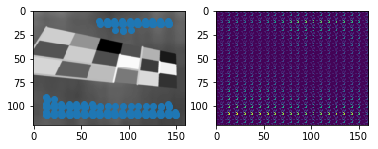

In [101]:
visualize_heatmap(img,outputs,0.000013)

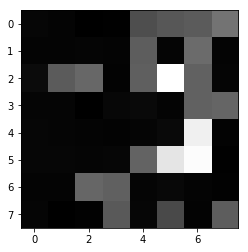

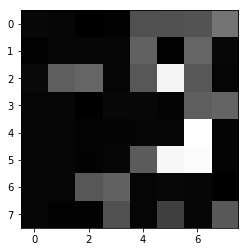

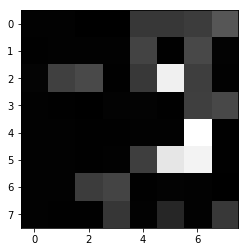

[[0.01693507 0.01587697 0.01304527 0.0141934  0.06361835 0.0696808
  0.07184719 0.08758815]
 [0.01566154 0.01568029 0.01648171 0.01616816 0.07313437 0.01644644
  0.08213463 0.01583386]
 [0.02047607 0.07219148 0.07974668 0.01529111 0.07478152 0.1779327
  0.07563595 0.01675155]
 [0.01688268 0.01635211 0.01310655 0.01811273 0.01907822 0.01573232
  0.07583192 0.07851651]
 [0.0170011  0.0165925  0.01616366 0.01553391 0.01634035 0.01892383
  0.16821864 0.01498349]
 [0.01718022 0.01699465 0.01676759 0.01730902 0.07697987 0.16073053
  0.175863   0.01410499]
 [0.01564888 0.01574746 0.07876462 0.07521373 0.01632552 0.01866659
  0.01604595 0.01437004]
 [0.01646904 0.01356628 0.01439615 0.07042321 0.01742807 0.0608257
  0.01509781 0.07318845]]


In [102]:
heatmap = output2heatmap(outputs)
plt.imshow(heatmap[:8,:8],cmap='gray')
plt.show()
plt.imshow(heatmap[5*8:6*8,7*8:8*8],cmap='gray')
plt.show()
plt.imshow(heatmap[3*8:4*8,12*8:13*8],cmap='gray')
plt.show()
print(heatmap[:8,:8]/np.max(heatmap))

/home/luo3300612/.local/share/virtualenvs/mySuperPoint-tDjnSeaF/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/home/luo3300612/.local/share/virtualenvs/mySuperPoint-tDjnSeaF/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


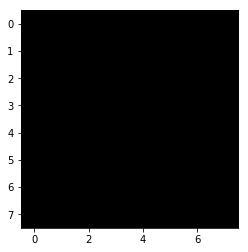

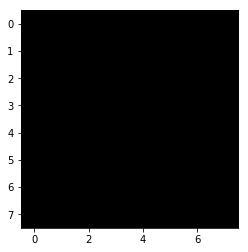

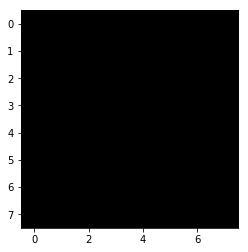

[[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]


In [128]:
heatmap = output2heatmap(outputs)
plt.imshow(heatmap[:8,:8],cmap='gray')
plt.show()
plt.imshow(heatmap[5*8:6*8,7*8:8*8],cmap='gray')
plt.show()
plt.imshow(heatmap[3*8:4*8,12*8:13*8],cmap='gray')
plt.show()
print(heatmap[:8,:8]/np.max(heatmap))

In [105]:
img = img.squeeze()

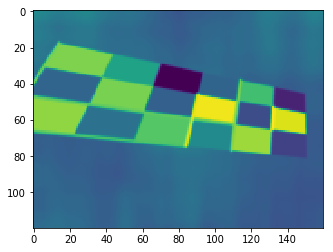

In [116]:
plt.imshow(img)

tensor([ 65.0196,  64.9020,  64.7176,  64.4863,  64.1922,  63.7804,  63.3451,
         62.9608,  62.6824,  62.4196,  62.2784,  62.2235,  62.2078,  62.2471,
         62.3882,  62.5373,  62.6353,  63.1216,  64.3137,  66.3137,  68.4039,
         70.4745,  72.4784,  74.5882,  76.2157,  77.2745,  78.2823,  79.3333,
         80.3569,  80.9921,  79.9608,  78.3451,  74.7961,  70.4000,  66.2392,
         63.0039,  59.9647,  58.7333,  60.1647,  62.2824,  64.8235,  67.4196,
         69.7451,  70.8510,  71.7059,  72.9647,  75.4588,  80.5647,  87.0235,
         93.6745,  97.9176,  97.6627,  95.5137,  93.0392,  93.1177,  95.4196,
         99.2745, 101.7686, 104.1608, 104.2314, 102.5569,  99.8706,  97.2745,
         97.0863, 100.2784, 103.5412, 100.6157,  94.0627,  88.6745,  87.4353,
         86.7294,  84.9490,  81.2118,  77.4667,  74.1961,  70.6706,  68.2000,
         66.1922,  61.3647,  56.9804,  56.3882,  57.0118,  57.1137,  57.1412,
         57.1176,  57.0471,  56.9255,  56.8392,  56.6902,  56.55

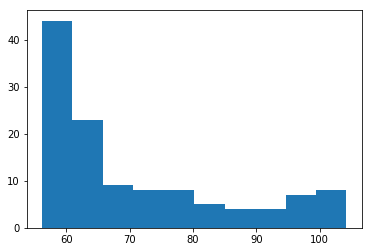

In [108]:
plt.hist(img.sum(dim=1))
print(img.sum(dim=1))

In [113]:
print(np.max(img))
print(np.min(img))

TypeError: max() missing 1 required positional arguments: "dim"

In [114]:
img.shape

torch.Size([120, 160])

In [115]:
img.type

<function Tensor.type>

In [120]:
label.shape

torch.Size([1, 15, 20])

In [121]:
label

tensor([[[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [64, 22, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [61, 64, 64, 64, 64,  4, 64, 64, 46, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [64, 64, 64, 64, 46, 64, 64, 64, 64, 64, 64, 21, 64, 64, 50, 64, 64,
          64, 64, 64],
         [64, 64, 64, 64, 64, 64, 64, 64, 18, 64, 64, 51, 64, 64, 64, 64, 21,
          64, 45, 64],
         [64, 64, 64, 30, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 17, 64, 44,
          64, 64, 64],
         [64, 64, 64, 64, 64, 64, 64,  5, 64, 64, 31, 64, 64, 63, 64, 64, 64,
          64,  6, 64],
         [64, 64, 38, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 12,
          64, 38, 64],
         [64, 64, 64, 64, 64, 64,  7, 64, 64, 64, 20, 64, 64, 45, 64, 64, 59,
          64,

max point: [] []
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
max :nan
min :nan
dim : (120, 160)
sum : nan
dim1 sum: [ 0.  0.  0.  0.  0. nan nan nan  0. nan nan nan nan nan nan nan  0. nan
 nan nan nan nan nan nan  0. nan nan nan nan nan nan nan  0. nan nan nan
 nan nan nan nan  0. nan nan nan nan nan nan nan  0.  0.  0.  0. nan nan
 nan nan  0.  0.  0.  0. nan nan nan nan  0.  0. nan nan nan nan nan nan
  0. nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan  0. nan
 nan nan nan nan nan nan  0. nan nan nan nan nan nan nan  0. nan nan nan
 nan nan nan nan  0. nan nan nan nan nan nan nan  0. nan nan nan nan nan
 nan nan  0.  0.  0. nan nan nan nan nan  0.  0.  0. nan nan nan nan nan
  0.  0.  0. nan nan nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0.]


/home/luo3300612/.local/share/virtualenvs/mySuperPoint-tDjnSeaF/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/luo3300612/.local/share/virtualenvs/mySuperPoint-tDjnSeaF/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/luo3300612/.local/share/virtualenvs/mySuperPoint-tDjnSeaF/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal


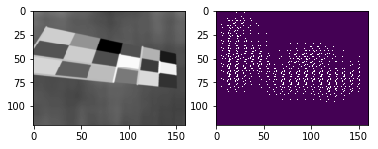

In [129]:
visualize_heatmap(img,outputs)

In [130]:
outputs

tensor([[[[-11.1030, -18.7859, -23.0519,  ..., -23.2945, -21.3555, -20.0544],
          [-14.3942, -24.5225, -31.0646,  ..., -28.0335, -25.6748, -26.7314],
          [-15.9414, -25.3892, -30.5925,  ..., -26.8614, -25.4101, -28.4940],
          ...,
          [-11.9978, -19.5224, -22.1804,  ..., -23.7087, -21.9909, -22.6250],
          [-12.1766, -20.3623, -22.4811,  ..., -23.2484, -21.7557, -20.8847],
          [-11.7360, -18.4064, -19.8610,  ..., -18.6767, -17.3427, -14.8916]],

         [[-10.7253, -16.0279, -16.9012,  ..., -16.9929, -16.9236, -14.9206],
          [-12.0455, -19.0410, -18.8927,  ..., -20.4863, -22.0547, -21.7538],
          [-13.1676, -23.5605, -24.9291,  ..., -24.5516, -26.3905, -24.7143],
          ...,
          [-10.6842, -23.2625, -25.3279,  ..., -27.2652, -25.8932, -22.4026],
          [-12.3612, -26.7622, -29.5607,  ..., -27.3414, -26.7872, -23.2068],
          [-13.3808, -23.9716, -26.2235,  ..., -23.3261, -22.1280, -16.6428]],

         [[-24.3249, -39.0533,

In [131]:
outputs.shape

torch.Size([1, 65, 15, 20])

In [132]:
img

tensor([[[[0.4902, 0.4902, 0.4902,  ..., 0.4667, 0.4627, 0.4588],
          [0.4902, 0.4902, 0.4902,  ..., 0.4627, 0.4588, 0.4588],
          [0.4863, 0.4863, 0.4863,  ..., 0.4588, 0.4549, 0.4549],
          ...,
          [0.3804, 0.3804, 0.3804,  ..., 0.3216, 0.3216, 0.3216],
          [0.3843, 0.3804, 0.3804,  ..., 0.3216, 0.3216, 0.3216],
          [0.3843, 0.3843, 0.3843,  ..., 0.3216, 0.3216, 0.3216]]]])

In [133]:
label

tensor([[[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [64, 22, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [61, 64, 64, 64, 64,  4, 64, 64, 46, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [64, 64, 64, 64, 46, 64, 64, 64, 64, 64, 64, 21, 64, 64, 50, 64, 64,
          64, 64, 64],
         [64, 64, 64, 64, 64, 64, 64, 64, 18, 64, 64, 51, 64, 64, 64, 64, 21,
          64, 45, 64],
         [64, 64, 64, 30, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 17, 64, 44,
          64, 64, 64],
         [64, 64, 64, 64, 64, 64, 64,  5, 64, 64, 31, 64, 64, 63, 64, 64, 64,
          64,  6, 64],
         [64, 64, 38, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 12,
          64, 38, 64],
         [64, 64, 64, 64, 64, 64,  7, 64, 64, 64, 20, 64, 64, 45, 64, 64, 59,
          64,

In [137]:
torch.argmax(outputs,dim=1)

tensor([[[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [64, 22, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [61, 64, 64, 64, 64,  4, 64, 64, 46, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64],
         [64, 64, 64, 64, 46, 64, 64, 64, 64, 64, 64, 21, 64, 64, 50, 64, 64,
          64, 64, 64],
         [64, 64, 64, 64, 64, 64, 64, 64, 18, 64, 64, 51, 64, 64, 64, 64, 21,
          64, 45, 64],
         [64, 64, 64, 30, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 17, 64, 44,
          64, 64, 64],
         [64, 64, 64, 64, 64, 64, 64,  5, 64, 64, 31, 64, 64, 63, 64, 64, 64,
          64,  6, 64],
         [64, 64, 38, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 12,
          64, 38, 64],
         [64, 64, 64, 64, 64, 64,  7, 64, 64, 64, 20, 64, 64, 45, 64, 64, 59,
          64,

In [139]:
outputs_after = outputs/(torch.max(outputs)-torch.min(outputs))

In [140]:
outputs_after

tensor([[[[-0.0383, -0.0647, -0.0794,  ..., -0.0803, -0.0736, -0.0691],
          [-0.0496, -0.0845, -0.1071,  ..., -0.0966, -0.0885, -0.0921],
          [-0.0549, -0.0875, -0.1054,  ..., -0.0926, -0.0876, -0.0982],
          ...,
          [-0.0413, -0.0673, -0.0764,  ..., -0.0817, -0.0758, -0.0780],
          [-0.0420, -0.0702, -0.0775,  ..., -0.0801, -0.0750, -0.0720],
          [-0.0404, -0.0634, -0.0684,  ..., -0.0644, -0.0598, -0.0513]],

         [[-0.0370, -0.0552, -0.0582,  ..., -0.0586, -0.0583, -0.0514],
          [-0.0415, -0.0656, -0.0651,  ..., -0.0706, -0.0760, -0.0750],
          [-0.0454, -0.0812, -0.0859,  ..., -0.0846, -0.0910, -0.0852],
          ...,
          [-0.0368, -0.0802, -0.0873,  ..., -0.0940, -0.0892, -0.0772],
          [-0.0426, -0.0922, -0.1019,  ..., -0.0942, -0.0923, -0.0800],
          [-0.0461, -0.0826, -0.0904,  ..., -0.0804, -0.0763, -0.0574]],

         [[-0.0838, -0.1346, -0.1574,  ..., -0.1323, -0.1231, -0.0966],
          [-0.1064, -0.1713, -

max point: [  0   0   0 ... 119 119 119] [  0   1   2 ... 157 158 159]
[[4.8377515e-05 4.8440517e-05 4.6222558e-05 ... 5.4265536e-05
  5.5272016e-05 5.5772762e-05]
 [4.6966143e-05 4.6227771e-05 4.7886959e-05 ... 4.7145280e-05
  5.5889450e-05 4.7111324e-05]
 [4.7984126e-05 5.6742567e-05 5.6708417e-05 ... 5.7492081e-05
  5.5175689e-05 4.8280726e-05]
 ...
 [4.7689948e-05 4.8695591e-05 4.8194051e-05 ... 5.6696634e-05
  5.5759603e-05 4.7045549e-05]
 [4.8076632e-05 4.7877704e-05 5.4743163e-05 ... 4.7689635e-05
  4.8492147e-05 4.7257210e-05]
 [4.7141457e-05 4.7274814e-05 4.6862755e-05 ... 5.1180141e-05
  4.6989615e-05 5.4475142e-05]]
max :0.0000817
min :0.0000378
dim : (120, 160)
sum : 0.97733694
dim1 sum: [0.00553294 0.005677   0.00584569 0.00591333 0.00627486 0.00655689
 0.00656173 0.00623087 0.00530584 0.00557385 0.00571229 0.00586262
 0.00647847 0.0066152  0.00718538 0.00630731 0.00532926 0.00560491
 0.00572502 0.00586522 0.00652886 0.00653976 0.00716076 0.00627961
 0.00537966 0.00564605 

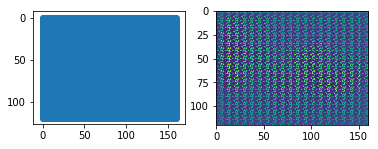

In [141]:
visualize_heatmap(img,outputs_after,)

max point: [ 8  8 10 10 14 14 14 14 15 16 16 16 16 18 18 18 18 18 22 22 23 24 24 24
 24 26 26 26 29 29 30 31 31 32 32 32 32 32 34 34 34 34 34 37 37 37 37 37
 37 38 38 38 38 39 40 40 40 40 40 40 40 40 40 40 42 42 42 42 42 42 42 42
 42 42 42 43 43 43 45 45 45 45 45 45 45 45 45 45 45 45 45 46 46 46 46 46
 46 46 46 46 46 46 47 47 47 48 48 48 48 48 48 48 48 48 48 48 49 50 50 50
 50 50 50 50 50 50 50 51 51 51 51 51 51 51 51 51 51 51 53 53 53 53 53 53
 53 53 53 53 53 53 53 53 53 53 53 54 54 54 54 54 54 55 55 55 55 55 55 55
 55 56 56 56 56 56 56 56 56 56 56 56 56 57 57 57 57 57 57 58 58 58 58 58
 58 58 58 58 58 59 59 59 59 59 59 59 59 59 59 59 59 60 60 60 61 61 61 61
 61 61 61 61 61 61 61 63 63 63 63 63 63 63 63 63 63 63 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 65 65 65 65 65 65 65 65 65 65 65 65
 66 66 66 66 66 66 66 66 66 66 66 66 67 67 67 67 67 67 67 67 67 68 68 68
 68 68 68 68 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69
 69 69 71 71 71 71 71 71 71 71 71 71 71 

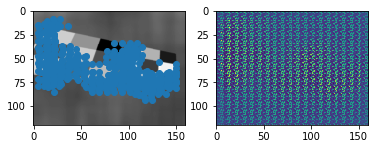

In [147]:
visualize_heatmap(img,outputs_after,0.000070)

In [155]:
outputs

tensor([[[[ -3.3636,  -5.3642,  -8.4267,  ...,  -3.3650,  -3.3302,  -2.6497],
          [ -4.2916,  -7.4922, -15.6640,  ...,  -4.7455,  -4.5667,  -3.8553],
          [ -3.0176,  -7.3143, -18.3692,  ...,  -8.3273,  -7.3995,  -5.0878],
          ...,
          [ -1.8205,  -2.8489,  -3.0510,  ...,  -6.7356,  -4.4035,  -2.6657],
          [ -1.3153,  -1.9409,  -2.1561,  ...,  -3.1235,  -2.7426,  -2.3455],
          [ -0.9812,  -1.3637,  -1.4726,  ...,  -2.1373,  -2.0421,  -1.8181]],

         [[ -3.7990,  -5.9983,  -8.9189,  ...,  -3.4453,  -2.8113,  -2.5010],
          [ -5.0284,  -9.5219, -17.6974,  ...,  -4.6282,  -3.2124,  -3.1612],
          [ -5.4220,  -9.9831, -18.6269,  ...,  -7.3983,  -5.2849,  -4.0430],
          ...,
          [ -2.3210,  -3.2989,  -3.2539,  ...,  -6.3494,  -3.3578,  -2.3104],
          [ -1.7221,  -2.2001,  -2.3830,  ...,  -3.3795,  -2.8687,  -2.5578],
          [ -1.3721,  -1.6457,  -1.7184,  ...,  -2.5516,  -2.3829,  -2.1018]],

         [[ -1.9230,  -2.9668,

In [156]:
outputs.shape

torch.Size([1, 65, 15, 20])

In [157]:
outputs_no_N = torch.squeeze(outputs)

([array([0., 0., 0., 0., 0., 0., 1., 4., 3., 7.]),
  array([0., 0., 0., 3., 1., 2., 1., 1., 4., 3.]),
  array([1., 0., 0., 0., 4., 1., 3., 1., 2., 3.]),
  array([1., 0., 0., 0., 1., 4., 4., 1., 1., 3.]),
  array([1., 0., 0., 1., 3., 2., 1., 3., 1., 3.]),
  array([0., 0., 1., 0., 3., 2., 1., 3., 2., 3.]),
  array([0., 0., 0., 3., 0., 2., 2., 3., 1., 4.]),
  array([0., 0., 0., 1., 1., 1., 3., 4., 2., 3.]),
  array([0., 0., 0., 0., 0., 4., 2., 4., 1., 4.]),
  array([0., 0., 2., 1., 2., 2., 1., 2., 1., 4.]),
  array([0., 0., 0., 0., 0., 4., 3., 3., 1., 4.]),
  array([0., 0., 0., 0., 2., 1., 4., 0., 4., 4.]),
  array([0., 1., 1., 2., 0., 2., 0., 2., 2., 5.]),
  array([0., 1., 0., 0., 1., 1., 2., 2., 3., 5.]),
  array([0., 0., 1., 0., 1., 3., 3., 0., 2., 5.]),
  array([0., 1., 1., 1., 3., 1., 0., 2., 1., 5.]),
  array([0., 0., 0., 0., 1., 4., 1., 3., 2., 4.]),
  array([0., 0., 0., 4., 2., 1., 1., 1., 2., 4.]),
  array([0., 0., 0., 0., 2., 0., 3., 2., 2., 6.]),
  array([1., 0., 1., 2., 1., 0.

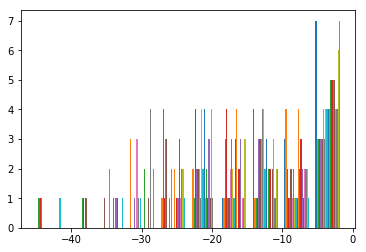

In [160]:
plt.hist(outputs_no_N[1,:,:].detach().numpy())

([array([7., 2., 4., 2., 0., 0., 0., 0., 0., 0.]),
  array([5., 2., 0., 1., 3., 2., 2., 0., 0., 0.]),
  array([3., 2., 1., 1., 1., 1., 2., 3., 1., 0.]),
  array([3., 2., 0., 2., 1., 2., 1., 1., 3., 0.]),
  array([3., 2., 0., 1., 4., 1., 0., 1., 2., 1.]),
  array([3., 1., 2., 1., 2., 3., 0., 2., 1., 0.]),
  array([3., 2., 2., 1., 2., 2., 2., 1., 0., 0.]),
  array([3., 1., 2., 2., 4., 1., 2., 0., 0., 0.]),
  array([4., 1., 1., 1., 1., 4., 1., 2., 0., 0.]),
  array([4., 1., 0., 2., 0., 5., 2., 1., 0., 0.]),
  array([4., 1., 1., 4., 2., 0., 3., 0., 0., 0.]),
  array([4., 5., 0., 2., 0., 0., 2., 1., 0., 1.]),
  array([6., 2., 0., 1., 1., 1., 2., 0., 1., 1.]),
  array([5., 3., 0., 1., 1., 2., 1., 2., 0., 0.]),
  array([6., 1., 1., 0., 1., 1., 3., 2., 0., 0.]),
  array([5., 2., 0., 0., 1., 1., 2., 4., 0., 0.]),
  array([4., 2., 1., 0., 3., 1., 1., 2., 1., 0.]),
  array([4., 2., 1., 1., 3., 0., 0., 2., 0., 2.]),
  array([5., 1., 2., 1., 2., 0., 0., 1., 1., 2.]),
  array([6., 2., 1., 1., 1., 0.

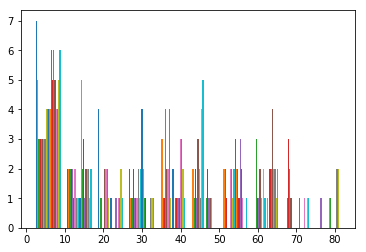

In [164]:
plt.hist(outputs_no_N[59,:,:].detach().numpy())

In [170]:
outputs

tensor([[[[ -3.5814,  -6.0803,  -9.1948,  ...,  -2.8519,  -2.5987,  -2.0180],
          [ -5.4261,  -9.5307, -14.0084,  ...,  -5.2733,  -4.5961,  -3.3833],
          [ -6.8737, -12.0937, -16.2468,  ...,  -9.0069,  -7.5014,  -4.8988],
          ...,
          [ -3.0359,  -5.0120,  -5.7745,  ...,  -8.9075,  -6.9992,  -4.6896],
          [ -2.7556,  -4.4309,  -5.0591,  ...,  -5.5345,  -5.0984,  -3.9026],
          [ -2.0302,  -3.0879,  -3.4831,  ...,  -3.5317,  -3.3921,  -2.6679]],

         [[ -3.7214,  -6.5637, -10.2632,  ...,  -3.3962,  -3.1600,  -2.2646],
          [ -5.1921,  -9.3483, -14.5158,  ...,  -6.3118,  -5.5157,  -3.7828],
          [ -6.2047, -11.6904, -16.7483,  ..., -10.8362,  -8.9219,  -5.6289],
          ...,
          [ -3.5914,  -5.8639,  -6.8354,  ..., -10.7659,  -8.5453,  -5.4984],
          [ -3.2378,  -5.2129,  -5.9914,  ...,  -6.6305,  -6.1047,  -4.4142],
          [ -2.2169,  -3.4819,  -3.9548,  ...,  -4.0108,  -3.8893,  -2.9252]],

         [[ -3.4290,  -5.7700,

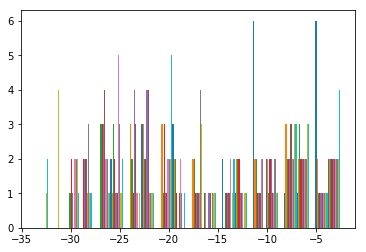

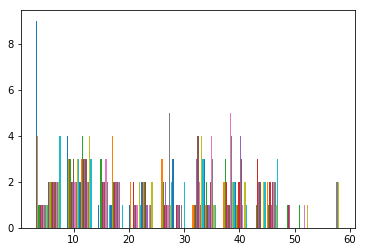

In [172]:
outputs_no_N = torch.squeeze(outputs)
plt.hist(outputs_no_N[1,:,:].detach().numpy())
plt.show()
plt.hist(outputs_no_N[59,:,:].detach().numpy())
plt.show()

In [175]:
outputs

tensor([[[[ -6.4471,  -9.8544, -14.5110,  ..., -12.7466, -11.6021,  -7.6883],
          [-11.0051, -17.6034, -28.3606,  ..., -22.5136, -17.4491, -11.9100],
          [ -9.9340, -16.3989, -30.1540,  ..., -29.5728, -22.1311, -15.4587],
          ...,
          [ -7.8742, -15.6607, -19.3212,  ..., -18.8636, -12.3497, -10.3869],
          [ -7.0777, -14.2426, -16.3030,  ..., -15.8245, -10.0777,  -8.2724],
          [ -5.4345,  -9.7159,  -9.3696,  ...,  -8.6847,  -5.1006,  -4.8764]],

         [[ -5.2747,  -9.8525, -15.3135,  ..., -12.9255, -12.2828,  -7.6631],
          [ -8.4439, -16.7705, -27.7022,  ..., -22.4579, -19.5024, -12.1214],
          [ -8.1236, -17.7608, -31.4608,  ..., -29.3882, -24.9334, -15.8833],
          ...,
          [ -7.0442, -14.9302, -19.6969,  ..., -19.7846, -15.0043, -10.6846],
          [ -6.2627, -13.2983, -16.5288,  ..., -16.0242, -12.0956,  -8.8570],
          [ -4.5945,  -8.9147,  -9.6055,  ...,  -8.9949,  -6.7711,  -5.4213]],

         [[ -5.2209, -10.0310,

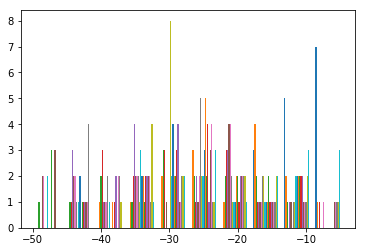

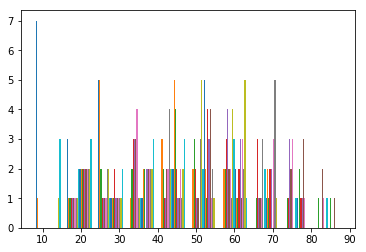

In [176]:
outputs_no_N = torch.squeeze(outputs)
plt.hist(outputs_no_N[1,:,:].detach().numpy())
plt.show()
plt.hist(outputs_no_N[59,:,:].detach().numpy())
plt.show()

In [179]:
outputs

tensor([[[[ -3.0008,  -5.6862,  -7.7196,  ..., -11.9217,  -9.9427,  -7.4562],
          [ -3.5087,  -6.6638,  -9.7361,  ..., -16.7954, -13.3438, -10.3972],
          [ -2.4064,  -5.5660,  -8.5397,  ..., -16.7393, -13.0510, -10.6047],
          ...,
          [ -8.7635, -15.9805, -20.0651,  ..., -17.0630, -14.6797, -11.7930],
          [ -8.1413, -14.8401, -18.7885,  ..., -17.9806, -15.1167, -11.4521],
          [ -5.6406,  -9.9081, -12.3900,  ..., -12.1216, -10.2067,  -7.4035]],

         [[ -4.3518,  -6.5490,  -8.2829,  ..., -14.7224, -12.2677,  -7.7696],
          [ -4.8233,  -6.3593,  -8.4520,  ..., -20.5607, -17.0149, -11.2511],
          [ -3.3626,  -4.5189,  -5.9639,  ..., -20.9258, -17.5317, -11.9676],
          ...,
          [-13.1377, -20.9806, -24.8927,  ..., -21.4438, -18.3331, -12.8198],
          [-11.3752, -18.3561, -22.2775,  ..., -20.9147, -17.7970, -12.2345],
          [ -6.7093, -10.7168, -13.1282,  ..., -12.9204, -10.9946,  -7.6293]],

         [[ -4.2152,  -6.1626,

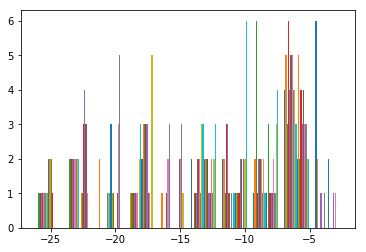

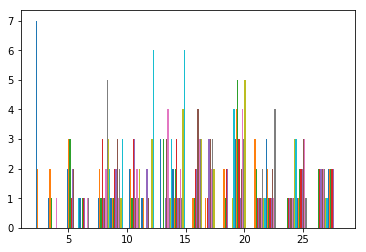

In [180]:
outputs_no_N = torch.squeeze(outputs)
plt.hist(outputs_no_N[1,:,:].detach().numpy())
plt.show()
plt.hist(outputs_no_N[59,:,:].detach().numpy())
plt.show()

In [183]:
outputs

tensor([[[[ -6.1297,  -8.8106, -10.4492,  ..., -17.5436, -14.3783,  -9.7523],
          [ -7.4671,  -9.9945, -12.4793,  ..., -22.1021, -17.7444, -12.0030],
          [ -6.5050,  -8.3584,  -9.9867,  ..., -21.8676, -17.4976, -12.3909],
          ...,
          [-16.9521, -25.3884, -28.2051,  ..., -25.9430, -21.3137, -14.2572],
          [-15.4438, -23.4600, -26.0350,  ..., -24.6731, -20.2626, -13.0438],
          [ -9.1286, -13.7559, -15.6406,  ..., -15.0175, -12.4937,  -8.0661]],

         [[ -6.8257,  -9.2873,  -9.9462,  ..., -12.7810,  -9.7749,  -6.5904],
          [ -8.7297, -10.8352, -11.6032,  ..., -17.5942, -12.2401,  -8.2556],
          [ -6.5125,  -7.8301,  -7.8287,  ..., -17.8172, -12.3793,  -8.6030],
          ...,
          [-15.5768, -22.8146, -24.4156,  ..., -20.9607, -15.7421, -10.1415],
          [-15.0455, -22.0133, -23.7363,  ..., -21.5425, -16.2343,  -9.9090],
          [-10.5538, -15.4140, -16.8691,  ..., -15.5769, -12.0022,  -7.0238]],

         [[ -5.0881,  -7.8938,

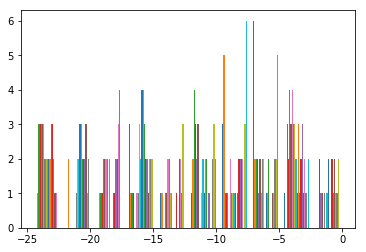

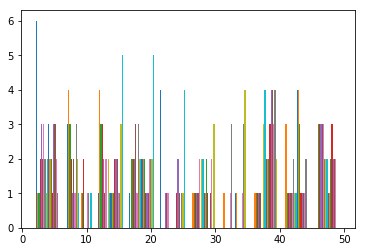

In [184]:
outputs_no_N = torch.squeeze(outputs)
plt.hist(outputs_no_N[1,:,:].detach().numpy())
plt.show()
plt.hist(outputs_no_N[59,:,:].detach().numpy())
plt.show()

In [188]:
outputs

tensor([[[[-0.0681, -0.0716, -0.0747,  ..., -0.0751, -0.0781, -0.0868],
          [-0.0734, -0.0693, -0.0723,  ..., -0.0738, -0.0829, -0.1097],
          [-0.0758, -0.0682, -0.0706,  ..., -0.0730, -0.0842, -0.1121],
          ...,
          [-0.0750, -0.0672, -0.0691,  ..., -0.0715, -0.0830, -0.1114],
          [-0.0701, -0.0628, -0.0641,  ..., -0.0662, -0.0751, -0.1068],
          [-0.0604, -0.0597, -0.0584,  ..., -0.0593, -0.0626, -0.0854]],

         [[-0.1823, -0.2815, -0.3096,  ..., -0.3095, -0.2867, -0.1833],
          [-0.2805, -0.4337, -0.4739,  ..., -0.4735, -0.4361, -0.2737],
          [-0.3023, -0.4725, -0.5184,  ..., -0.5162, -0.4716, -0.2929],
          ...,
          [-0.3014, -0.4726, -0.5178,  ..., -0.5162, -0.4722, -0.2932],
          [-0.2770, -0.4355, -0.4743,  ..., -0.4723, -0.4351, -0.2733],
          [-0.1866, -0.2904, -0.3143,  ..., -0.3132, -0.2902, -0.1869]],

         [[-0.1955, -0.2367, -0.2430,  ..., -0.2398, -0.2158, -0.1424],
          [-0.2571, -0.3205, -

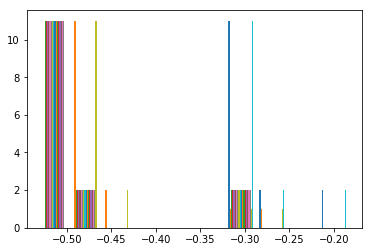

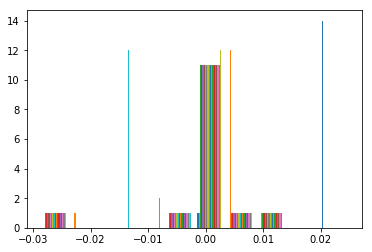

In [189]:
outputs_no_N = torch.squeeze(outputs)
plt.hist(outputs_no_N[1,:,:].detach().numpy())
plt.show()
plt.hist(outputs_no_N[59,:,:].detach().numpy())
plt.show()

In [199]:
outputs_no_N.argmax(dim=0)

tensor([[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [6

In [200]:
outputs_no_N = torch.squeeze(outputs)
outputs_no_N.argmax(dim=0)

tensor([[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          6, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         38, 64],
        [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64],
        [6

In [201]:
outputs

tensor([[[[-1.7912, -2.7058, -3.1696,  ..., -3.5480, -3.1476, -2.2950],
          [-2.1669, -3.3902, -3.9996,  ..., -4.7496, -4.1172, -3.1308],
          [-1.9602, -3.0937, -3.4602,  ..., -4.2164, -3.5960, -2.8259],
          ...,
          [-2.6382, -4.4126, -4.9831,  ..., -3.6385, -3.3856, -2.6881],
          [-2.2737, -4.0251, -4.5740,  ..., -3.9820, -3.6012, -2.7028],
          [-1.4797, -2.6212, -2.9410,  ..., -2.7591, -2.4354, -1.8654]],

         [[-3.3205, -4.9343, -5.3779,  ..., -5.9995, -5.0647, -3.7294],
          [-4.9519, -7.1313, -7.3466,  ..., -8.0590, -6.7021, -4.8415],
          [-5.4022, -7.2400, -7.1562,  ..., -7.3154, -5.9764, -4.4724],
          ...,
          [-4.9892, -7.8556, -8.6551,  ..., -6.5182, -5.8083, -4.3617],
          [-4.4098, -7.0014, -7.7314,  ..., -6.7846, -5.9239, -4.1744],
          [-2.8300, -4.3615, -4.7413,  ..., -4.3497, -3.7152, -2.4832]],

         [[-2.1157, -2.8577, -3.4042,  ..., -4.9272, -4.0324, -3.0474],
          [-2.5967, -3.2216, -